In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout

import json
import matplotlib.pyplot as plt

In [2]:
import random

random.seed(10)

# Carga de datos

In [3]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/validation.csv")

In [4]:
train_data.head()

,sequence_id,target
0,1,bathroom
1,1,bathroom
2,1,bathroom
3,1,bathroom
4,1,bathroom


# Analisis Exploratorio

In [5]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
print(f"Frases unicas : {train_data.target.unique()}")

--------------------Train data--------------------
Cantidad de filas : 7926
Frases unicas : ['bathroom' 'cat' 'dog' 'eat food' 'father' 'fine' 'finish' 'go to'
 'hello' 'help' 'learn' 'like' 'me' 'milk' 'more' 'mother' 'no' 'please'
 'repeat' 'see you later' 'sign' 'thank you' 'want' 'what' 'yes']


In [6]:
print("--------------------Validation data--------------------")
print(f"Cantidad de filas : {test_data.shape[0]}")
print(f"Frases unicas : {test_data.target.unique()}")

--------------------Validation data--------------------
Cantidad de filas : 547
Frases unicas : ['bathroom' 'cat' 'dog' 'eat food' 'father' 'fine' 'finish' 'go to'
 'hello' 'help' 'learn' 'like' 'me' 'milk' 'more' 'mother' 'no' 'please'
 'repeat' 'see you later' 'sign' 'thank you' 'want' 'what' 'yes']


In [7]:
if (list(train_data.target.unique()) != list(test_data.target.unique())):
    raise ValueError("Error between target and train")

In [8]:
train_data.describe()

,sequence_id
count,7926.000000
mean,189.509084
std,111.681925
min,1.000000
25%,88.000000
50%,190.000000
75%,283.000000
max,385.000000


# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [9]:
def get_needed_cols():
    cols = []

    for i in range(21):
        cols.append(f'x_Right_hand_{i}')
        cols.append(f'y_Right_hand_{i}')
        cols.append(f'x_Left_hand_{i}')
        cols.append(f'y_Left_hand_{i}')
    
    return cols

In [10]:
df = pd.read_csv("data/data.csv")
df_test = df[df['sequence_id'].isin(test_data['sequence_id'])]
df_train = df[df['sequence_id'].isin(train_data['sequence_id'])]

In [11]:
df.head()

,sequence_id,target,x_Left_hand_0,y_Left_hand_0,x_Left_hand_1,y_Left_hand_1,x_Left_hand_2,y_Left_hand_2,x_Left_hand_3,y_Left_hand_3,...,x_Right_hand_16,y_Right_hand_16,x_Right_hand_17,y_Right_hand_17,x_Right_hand_18,y_Right_hand_18,x_Right_hand_19,y_Right_hand_19,x_Right_hand_20,y_Right_hand_20
0,1,bathroom,0.266263,0.473249,0.291757,0.440494,0.306219,0.404748,0.309409,0.371156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,bathroom,0.261615,0.447170,0.284930,0.408778,0.293976,0.367232,0.291804,0.332398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,bathroom,0.261583,0.431127,0.278761,0.387111,0.281090,0.341194,0.276046,0.306308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,bathroom,0.263054,0.418766,0.274931,0.371834,0.273662,0.329738,0.264274,0.300696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,bathroom,0.274704,0.416674,0.273656,0.368680,0.260158,0.332655,0.246035,0.309348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print(len(df))
print(len(df_test) == len(test_data))
print(len(df_train) == len(train_data))

8473
True
True


# Modelo

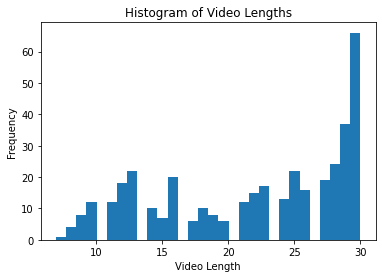

In [13]:
# Compute the lengths of the video sequences
video_lengths = df.groupby('sequence_id').size()
max_seq_length = video_lengths.max()
# max_seq_length = 30
# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [14]:
video_lengths.max()

30

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# Create a one-hot encoder
label_encoder = LabelEncoder()

In [16]:
def padding_videos(df):
    # Create a new DataFrame to store the filled rows
    filled_df = pd.DataFrame()
    target = []


    # Iterate over each group and fill remaining rows with zero
    for _, group in df.groupby('sequence_id'):
        remaining_rows = max_seq_length - len(group)
        zeros_df = pd.DataFrame([[0] * len(group.columns)] * remaining_rows, columns=group.columns)
        zeros_df['sequence_id'] = group['sequence_id'].unique()[0]
        zeros_df['target'] = group['target'].unique()[0]
        group = pd.concat([group, zeros_df])
    
        filled_df = filled_df.append(group)
        target.append(group["target"].unique()[0])
        
    filled_df.reset_index(drop=True, inplace=True)
    filled_df = filled_df.fillna(0)
    return filled_df, target

def padding_labels(target):
    integer_encoded = label_encoder.fit_transform(target)
    integer_encoded = integer_encoded.reshape(-1, 1)

    # Encode the word "Hello"
    onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False to get a numpy array as output
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [17]:
X_train, target = padding_videos(df_train)
y_train = padding_labels(target)

In [18]:

del X_train["sequence_id"] 
del X_train["target"] 

print(len(X_train), len(y_train))

10800 360


In [19]:
X_test, target = padding_videos(df_test)
y_test = padding_labels(target)
del X_test["sequence_id"] 
del X_test["target"] 

print(len(X_test), len(y_test))

750 25


In [20]:
len(y_train) + len(y_test) == len(df["sequence_id"].unique())

True

In [21]:
def flat_X(X):
    # Define the number of rows to be flattened
    rows_to_flatten = max_seq_length

    data_array = X.to_numpy()

    # Get the number of resulting rows in the output array
    resulting_rows = data_array.shape[0] // rows_to_flatten

    # Reshape the array to have (resulting_rows, rows_to_flatten, 80) shape
    reshaped_array = data_array[:resulting_rows * rows_to_flatten].reshape(resulting_rows, rows_to_flatten, -1)

    # Flatten the reshaped array along the second axis (axis=1) to get (resulting_rows, 13600) shape
    flattened_array = reshaped_array.reshape(resulting_rows, -1)

    return flattened_array

In [22]:
# expected_size =  num_classes * num_timesteps * num_features
# actual_size = X.iloc[:, :num_features].values.size
# if expected_size != actual_size:
#     raise ValueError("The total number of elements in the DataFrame does not match the expected size.")

In [23]:
num_samples = int(len(X_test)/max_seq_length)
num_features = len(get_needed_cols())
num_classes = len(y_test[1])

X_test = X_test.values.reshape(num_samples, max_seq_length, num_features)

In [24]:
len(X_train)

10800

In [25]:
num_samples_train = int(len(X_train)/max_seq_length)
num_features_train = len(get_needed_cols())
num_classes_train = len(y_train[1])

X_train = X_train.values.reshape(num_samples_train, max_seq_length, num_features_train)

In [26]:
# X_train = flat_X(X_train)
# X_test = flat_X(X_test)

In [27]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (360, 30, 84) (360, 25)
Test: (25, 30, 84) (25, 25)


# Modelo
La entrada son las coordenadas de las manos. Cada video cuenta con n cantidad de filas, 84 columnas (21 columnas por cada coordenada y por ambas manos).
La salida es la frase. La frase se representa por un entero que da el one hot encoder.

Se usa convoluciones para resaltar las caracteristicas en la entrada. Debido a que la entrada son coordenadas normalizadas de un video, se supone que funciona igual que si la entrada fuera una imagen. Estas redes extraen caracteristicas de forma automatica para clasificar objetos luego. Al buscar patrones, se espera que pueda predecir un video que ya ha sido entrenado previamente.

Se reduce el tamaño de la entrada haciendo uso de max pooling y flatten.

Se hace uso de Dense para conectar entradas con salidas.

Se hace uso de Dropout para evitar el sobreajuste.

Relu elimina negativos. 
Sigmoid nos ayuda a obtener la probabilidad de que un ejemplo pertenezca a la clase positiva.
Softmax hace clasificacion multiclase (en nuestro caso las palabras a predecir).

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [29]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(max_seq_length, num_features_train)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(num_classes_train, activation='softmax'))

In [30]:
# Create a sequential model
model = Sequential()
model.add(Convolution2D(32, (3, 3), strides=(1, 1), input_shape=(max_seq_length, num_features_train, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

# model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes_train, activation='softmax'))

In [31]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=8)

# Evaluate the model
score = model.evaluate(X_test, y_test)

# Print the accuracy
print('Test accuracy:', score[1])

Epoch 1/40
45/45 [==============================] - 1s 13ms/step - loss: 3.2188 - accuracy: 0.0361
Epoch 2/40
45/45 [==============================] - 1s 14ms/step - loss: 3.0431 - accuracy: 0.0861
Epoch 3/40
45/45 [==============================] - 1s 14ms/step - loss: 2.8132 - accuracy: 0.1361
Epoch 4/40
45/45 [==============================] - 1s 13ms/step - loss: 2.6765 - accuracy: 0.1333
Epoch 5/40
45/45 [==============================] - 1s 13ms/step - loss: 2.5188 - accuracy: 0.2056
Epoch 6/40
45/45 [==============================] - 1s 13ms/step - loss: 2.3790 - accuracy: 0.2167
Epoch 7/40
45/45 [==============================] - 1s 13ms/step - loss: 2.1838 - accuracy: 0.3306
Epoch 8/40
45/45 [==============================] - 1s 13ms/step - loss: 2.0353 - accuracy: 0.3333
Epoch 9/40
45/45 [==============================] - 1s 13ms/step - loss: 1.8262 - accuracy: 0.4250
Epoch 10/40
45/45 [==============================] - 1s 13ms/step - loss: 1.6972 - accuracy: 0.4417
Epoch 11/

In [32]:
# Get the predictions from the model
predictions = model.predict(X_test)

# Find the most likely prediction for each sample
most_likely_predictions = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 108ms/step


In [33]:
most_likely_predictions

array([ 0, 19,  2,  3,  4,  5,  6, 22,  5, 23, 10, 11, 12, 13, 14,  5, 16,
       17, 18, 19, 20, 17, 23, 20, 24], dtype=int64)

In [34]:
predicted_labels = label_encoder.inverse_transform(most_likely_predictions)

In [35]:
expected_labels = train_data.target.unique()

In [36]:
correct = 0
for i in range(len(predicted_labels)):
    if (predicted_labels[i] == expected_labels[i]):
        correct += 1
        print("Correctamente predicha: ", predicted_labels[i])

Correctamente predicha:  bathroom
Correctamente predicha:  dog
Correctamente predicha:  eat food
Correctamente predicha:  father
Correctamente predicha:  fine
Correctamente predicha:  finish
Correctamente predicha:  learn
Correctamente predicha:  like
Correctamente predicha:  me
Correctamente predicha:  milk
Correctamente predicha:  more
Correctamente predicha:  no
Correctamente predicha:  please
Correctamente predicha:  repeat
Correctamente predicha:  see you later
Correctamente predicha:  sign
Correctamente predicha:  yes


In [37]:
print("Correct >> ", correct)
print("Ratio >> ", str(correct/len(test_data.target.unique())))

Correct >>  17
Ratio >>  0.68
